In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Hao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Hao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data_file = 'data/Sentiment.csv'
data = pd.read_csv(data_file)
data = data[['text', 'sentiment']]

In [3]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

In [4]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [5]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', 'url', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', 'email', text)

    # Remove emojis
    text = remove_emojis(text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = nltk.word_tokenize(text.lower())

    # Lemmatize
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    tokens = [porter_stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)

In [6]:
cleaned_text = []

for i, text in enumerate(data['text']):
    cur = preprocess_text(text)
    cleaned_text.append(cur)

data['text'] = cleaned_text

In [7]:
train_data, temp_data = train_test_split(data, test_size=0.1, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [8]:
vectorizer = CountVectorizer(stop_words='english', max_features=2000)

In [9]:
X_train = vectorizer.fit_transform(train_data['text']).toarray()
X_test = vectorizer.transform(test_data['text']).toarray()
X_val = vectorizer.transform(val_data['text']).toarray()

In [10]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['sentiment'])
y_test = label_encoder.transform(test_data['sentiment'])
y_val = label_encoder.transform(val_data['sentiment'])

In [11]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.int64)

In [12]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
hidden_size = 128
num_epochs = 100
learning_rate = 0.001
patience = 10
stop_counter = 0
best_val_loss = np.inf

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct, train_total = 0, 0
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_dataloader))
    train_accuracy = train_correct / train_total * 100
    train_accuracies.append(train_accuracy)
    train_f1 = f1_score(y_train_tensor, model(X_train_tensor).argmax(dim=1), average='weighted')
    train_f1_scores.append(train_f1)

    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_dataloader))
    val_accuracy = val_correct / val_total * 100
    val_accuracies.append(val_accuracy)
    val_f1 = f1_score(y_val_tensor, model(X_val_tensor).argmax(dim=1), average='weighted')
    val_f1_scores.append(val_f1)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}')

    # if val_losses[-1] < best_val_loss:
    #     best_val_loss = val_losses[-1]
    #     stop_counter = 0
    #     torch.save(model.state_dict(), 'best_model.pt')
    # else:
    #     stop_counter += 1
    #     if stop_counter >= patience:
    #         print("Early stopping triggered.")
    #         break

# model.load_state_dict(torch.load('best_model.pt'))

model.eval()
test_loss = 0.0
test_correct, test_total = 0, 0
with torch.no_grad():
    for inputs, labels in val_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score(y_val_tensor, model(X_val_tensor).argmax(dim=1), average='weighted')

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1: {test_f1:.4f}')

Epoch [1/100], Train Loss: 0.8111, Train Accuracy: 65.22%, Train F1: 0.6884, Val Loss: 0.7602, Val Accuracy: 68.30%, Val F1: 0.6524
Epoch [2/100], Train Loss: 0.6789, Train Accuracy: 71.09%, Train F1: 0.7273, Val Loss: 0.7527, Val Accuracy: 68.01%, Val F1: 0.6535
Epoch [3/100], Train Loss: 0.6251, Train Accuracy: 73.62%, Train F1: 0.7537, Val Loss: 0.7582, Val Accuracy: 68.59%, Val F1: 0.6642
Epoch [4/100], Train Loss: 0.5923, Train Accuracy: 74.85%, Train F1: 0.7749, Val Loss: 0.7629, Val Accuracy: 69.74%, Val F1: 0.6789
Epoch [5/100], Train Loss: 0.5654, Train Accuracy: 76.40%, Train F1: 0.7895, Val Loss: 0.7779, Val Accuracy: 68.44%, Val F1: 0.6710
Epoch [6/100], Train Loss: 0.5364, Train Accuracy: 77.59%, Train F1: 0.7979, Val Loss: 0.7994, Val Accuracy: 68.30%, Val F1: 0.6652
Epoch [7/100], Train Loss: 0.5115, Train Accuracy: 78.83%, Train F1: 0.8158, Val Loss: 0.8081, Val Accuracy: 68.88%, Val F1: 0.6749
Epoch [8/100], Train Loss: 0.4864, Train Accuracy: 80.05%, Train F1: 0.8220,

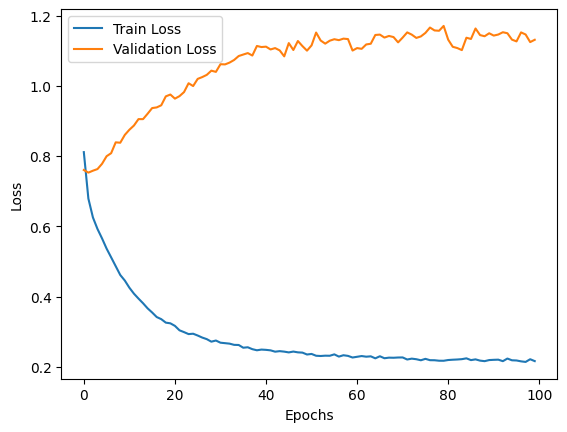

In [15]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

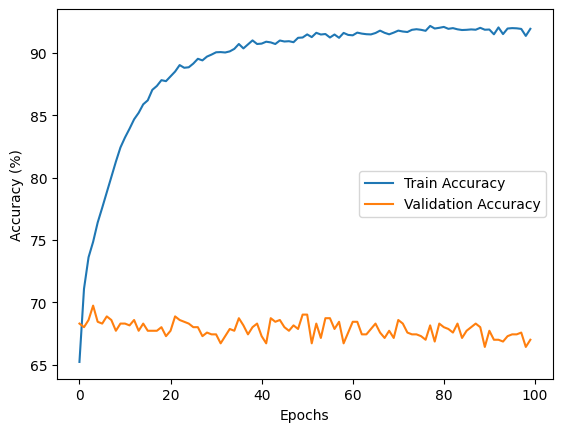

In [16]:
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

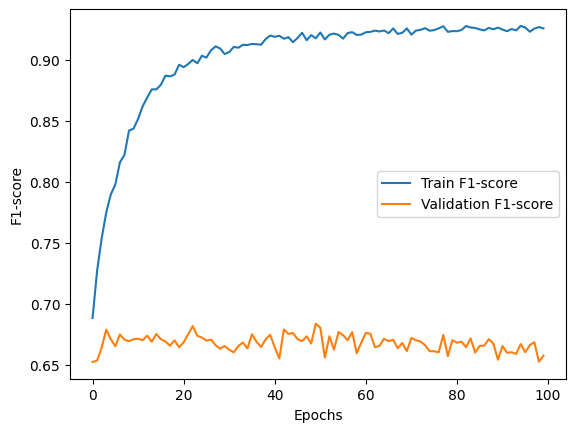

In [17]:
plt.figure()
plt.plot(train_f1_scores, label='Train F1-score')
plt.plot(val_f1_scores, label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()